<center><h2>Testing the Functionality of the <i>"utils.py"</i> Module</h2></center>

In [129]:
""" Tetsing the following functionality: 
    * metrics (rmsd, gdt_ts, gdt_ha, tmscore)
    * alignment (kabsch)
    * 3d coords (mds)
    -----
    The data files used contain the id of the original
    crystal structures from the RCSB PDB
"""

' Tetsing the following functionality: \n    * metrics (rmsd, gdt_ts, gdt_ha, tmscore)\n    * alignment (kabsch)\n    * 3d coords (mds)\n    -----\n    The data files used contain the id of the original\n    crystal structures from the RCSB PDB\n'

In [130]:
import os
import sys
# science
import numpy as np
import torch
import matplotlib.pyplot as plt
# molecular utils
import mdtraj
# functionality
sys.path.append("../")
from alphafold2_pytorch.utils import *

In [131]:
# load pdb file - has 1 more N_term than it should
prot = mdtraj.load_pdb("data/1h22_protein_chain_1.pdb").xyz[0].transpose()

## Metrics

In [132]:
# alter a small amount and measure metrics
pred = prot + (2*np.random.rand(*prot.shape) - 1) * 1

In [133]:
# Numpy
rmsd     = RMSD(prot, pred)
gdt_ha   = GDT(prot, pred, mode="HA")
gdt_ts   = GDT(prot, pred, mode="TS")
tm_score = TMscore(prot, pred)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

# Torch
prot, pred = torch.tensor(prot), torch.tensor(pred)
rmsd     = RMSD(prot, pred)
gdt_ha   = GDT(prot, pred, mode="HA")
gdt_ts   = GDT(prot, pred, mode="TS")
tm_score = TMscore(prot, pred)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

rmsd is:  [0.57595464]
gdt_ha is:  [0.64656102]
gdt_ts is:  [0.88105192]
tm_score is:  [0.99801521]
rmsd is:  tensor([0.5760], dtype=torch.float64)
gdt_ha is:  tensor([0.6466])
gdt_ts is:  tensor([0.8811])
tm_score is:  tensor([0.9980], dtype=torch.float64)


## Alignment

In [134]:
prot = prot.cpu().numpy()
pred = pred.cpu().numpy()

In [135]:
# rotation matrix
R = np.array([[0.25581, -0.77351, 0.57986],
              [-0.85333, -0.46255, -0.24057],
              [0.45429, -0.43327, -0.77839]])

In [136]:
# perturb protein (translation + rotation + random)
pred = prot + (2*np.random.rand(*prot.shape) - 1) * 1 
pred = np.dot(R, pred)

In [137]:
# check realignment works - torch
pred_mod_, prot_mod_ = kabsch_torch(torch.tensor(pred).double(), torch.tensor(prot).double())
rmsd_torch(prot_mod_, pred_mod_), tmscore_torch(prot_mod_, pred_mod_)

(tensor(0.5804, dtype=torch.float64), tensor(0.1668, dtype=torch.float64))

In [138]:
# check realignment works - numpy
pred_mod, prot_mod = kabsch_numpy(pred, prot)
rmsd_numpy(prot_mod, pred_mod), tmscore_numpy(prot_mod, pred_mod)

(0.5803989771209173, 0.16682909335653498)

## 3d Converter

In [139]:
prot_traj = mdtraj.load_pdb("data/1h22_protein_chain_1.pdb")

In [140]:
prot = prot_traj.xyz[0].transpose()

In [141]:
# works with a simple distance matrix for now
prot = torch.tensor(prot)
dist_mat = torch.cdist(prot.t(), prot.t())

In [142]:
# plt.imshow(distogram, cmap="viridis_r")

In [143]:
# select indices of backbone for angle calculation and selection
N_mask  = torch.tensor( prot_traj.topology.select("name == N and backbone") ).unsqueeze(0)
CA_mask = torch.tensor( prot_traj.topology.select("name == CA and backbone") ).unsqueeze(0) 
C_mask  = torch.tensor( prot_traj.topology.select("name == C and backbone")  ).unsqueeze(0)
CA_mask.shape, N_mask.shape, C_mask.shape

(torch.Size([1, 482]), torch.Size([1, 482]), torch.Size([1, 482]))

In [144]:
preds, stresses = MDScaling(torch.cat([dist_mat.cpu().unsqueeze(0)]*1, dim=0),
                            iters=250, tol=1e-5, fix_mirror=1,
                            N_mask=N_mask, CA_mask=CA_mask, C_mask=C_mask, verbose=2)

it: 0, stress tensor([1.1145e+08])
it: 1, stress tensor([55905616.])
it: 2, stress tensor([51025048.])
it: 3, stress tensor([48592192.])
it: 4, stress tensor([47377712.])
it: 5, stress tensor([46737880.])
it: 6, stress tensor([46368736.])
it: 7, stress tensor([46123448.])
it: 8, stress tensor([45926416.])
it: 9, stress tensor([45731676.])
it: 10, stress tensor([45507328.])
it: 11, stress tensor([45227024.])
it: 12, stress tensor([44864560.])
it: 13, stress tensor([44391248.])
it: 14, stress tensor([43775452.])
it: 15, stress tensor([42984244.])
it: 16, stress tensor([41986640.])
it: 17, stress tensor([40758880.])
it: 18, stress tensor([39291772.])
it: 19, stress tensor([37599336.])
it: 20, stress tensor([35723576.])
it: 21, stress tensor([33734096.])
it: 22, stress tensor([31718208.])
it: 23, stress tensor([29765976.])
it: 24, stress tensor([27948464.])
it: 25, stress tensor([26305908.])
it: 26, stress tensor([24848616.])
it: 27, stress tensor([23563130.])
it: 28, stress tensor([224213

it: 226, stress tensor([2.5095])
it: 227, stress tensor([1.7972])
it: 228, stress tensor([1.2878])
it: 229, stress tensor([0.9235])
it: 230, stress tensor([0.6628])
it: 231, stress tensor([0.4763])
it: 232, stress tensor([0.3429])
it: 233, stress tensor([0.2475])
it: 234, stress tensor([0.1792])
it: 235, stress tensor([0.1304])
it: 236, stress tensor([0.0954])
it: 237, stress tensor([0.0704])
it: 238, stress tensor([0.0524])
it: 239, stress tensor([0.0396])
it: 240, stress tensor([0.0304])
it: 241, stress tensor([0.0238])
it: 242, stress tensor([0.0191])
it: 243, stress tensor([0.0156])
it: 244, stress tensor([0.0132])
it: 245, stress tensor([0.0114])
it: 246, stress tensor([0.0102])
it: 247, stress tensor([0.0093])
it: 248, stress tensor([0.0087])
it: 249, stress tensor([0.0082])
Corrected mirror idxs: tensor([0])


In [41]:
preds.shape

torch.Size([1, 3, 7415])

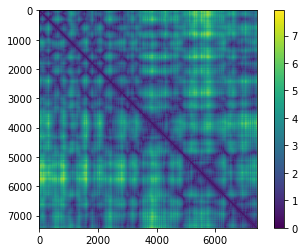

In [42]:
plt.imshow(torch.cdist(preds[0].t(), preds[0].t(), p=2).detach().numpy())
plt.colorbar()

In [39]:
preds[0], preds_svd.t()

(tensor([[ 0.7042,  0.5470,  0.6440,  ..., -1.8140, -1.6008, -1.6509],
         [-2.9869, -2.9606, -2.8374,  ..., -2.4883, -2.6455, -2.4319],
         [-1.7324, -1.6527, -1.5433,  ...,  0.6234,  0.8743,  0.7966]]),
 tensor([[2.2733, 2.2277, 2.1591,  ..., 2.1332, 2.1710, 2.0922],
         [1.5573, 1.5400, 1.5348,  ..., 0.7735, 0.7039, 0.6832],
         [0.1597, 0.1932, 0.1991,  ..., 1.0212, 1.0083, 0.9814]]))

In [124]:
# test SVD-based MDS
M = dist_mat.clone()**2
M = M[:1, :] + M[:, :1] - M
u,s,v = torch.svd_lowrank(M/2)
preds_svd = v@torch.diag(s).sqrt()[:, :3]

In [125]:
u.shape, s.shape, v.shape;
u, v

(tensor([[ 2.6778e-13,  2.2030e-08,  8.9199e-09,  8.1710e-09,  4.0161e-08,
           5.9591e-09],
         [ 2.9331e-04,  7.1718e-04,  9.7307e-04,  1.9176e-02, -2.2311e-02,
          -1.2564e-03],
         [ 7.0821e-04,  8.0095e-04,  1.8601e-04,  1.9363e-02, -2.0698e-02,
          -3.0620e-03],
         ...,
         [ 6.1822e-03,  1.8234e-02, -2.2530e-02,  2.6538e-02,  1.6164e-02,
           4.9385e-03],
         [ 6.6333e-03,  1.8450e-02, -2.4814e-02,  2.3624e-02,  6.7629e-03,
          -1.0307e-02],
         [ 6.9647e-03,  1.7279e-02, -2.4121e-02,  1.2881e-02,  9.1596e-04,
          -1.0201e-02]]),
 tensor([[ 6.2497e-13,  4.5870e-07,  7.0143e-08, -5.2181e-08, -1.3109e-07,
           2.2654e-07],
         [ 2.9331e-04,  7.1713e-04,  9.7308e-04, -1.9475e-02, -2.1708e-02,
           2.2526e-03],
         [ 7.0821e-04,  8.0095e-04,  1.8597e-04, -1.9041e-02, -1.9796e-02,
           7.5775e-05],
         ...,
         [ 6.1822e-03,  1.8234e-02, -2.2530e-02, -1.0780e-02, -8.6741e-03,
    

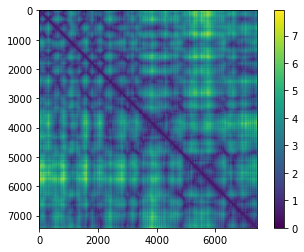

In [126]:
plt.imshow(torch.cdist(preds_svd, preds_svd, p=2).detach().numpy())
plt.colorbar()

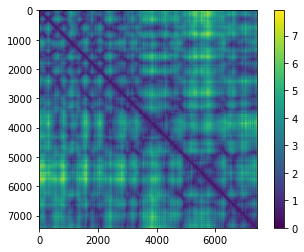

In [102]:
plt.imshow(dist_mat.detach().numpy())
plt.colorbar()

In [127]:
torch.cdist(preds[0].t(), preds[0].t(), p=2), dist_mat

(tensor([[0.0000e+00, 1.5018e-01, 2.4994e-01,  ..., 3.4545e+00, 3.6669e+00,
          3.6294e+00],
         [1.5018e-01, 0.0000e+00, 1.5249e-01,  ..., 3.4003e+00, 3.6159e+00,
          3.5764e+00],
         [2.4994e-01, 1.5249e-01, 1.3811e-03,  ..., 3.2787e+00, 3.4922e+00,
          3.4484e+00],
         ...,
         [3.4545e+00, 3.4003e+00, 3.2787e+00,  ..., 0.0000e+00, 2.4637e-01,
          3.0990e-01],
         [3.6669e+00, 3.6159e+00, 3.4922e+00,  ..., 2.4637e-01, 0.0000e+00,
          1.7965e-01],
         [3.6294e+00, 3.5764e+00, 3.4484e+00,  ..., 3.0990e-01, 1.7965e-01,
          0.0000e+00]]),
 tensor([[0.0000, 0.1502, 0.2499,  ..., 3.4551, 3.6676, 3.6300],
         [0.1502, 0.0000, 0.1525,  ..., 3.4009, 3.6166, 3.5770],
         [0.2499, 0.1525, 0.0000,  ..., 3.2793, 3.4928, 3.4490],
         ...,
         [3.4551, 3.4009, 3.2793,  ..., 0.0000, 0.2464, 0.3099],
         [3.6676, 3.6166, 3.4928,  ..., 0.2464, 0.0000, 0.1796],
         [3.6300, 3.5770, 3.4490,  ..., 0.3099, 0.1

In [128]:
torch.cdist(preds_svd, preds_svd, p=2)

tensor([[0.0000e+00, 1.5017e-01, 2.4991e-01,  ..., 3.4551e+00, 3.6675e+00,
         3.6300e+00],
        [1.5017e-01, 0.0000e+00, 1.5250e-01,  ..., 3.4009e+00, 3.6166e+00,
         3.5770e+00],
        [2.4991e-01, 1.5250e-01, 8.6317e-05,  ..., 3.2793e+00, 3.4928e+00,
         3.4490e+00],
        ...,
        [3.4551e+00, 3.4009e+00, 3.2793e+00,  ..., 1.3811e-03, 2.4642e-01,
         3.0992e-01],
        [3.6675e+00, 3.6166e+00, 3.4928e+00,  ..., 2.4642e-01, 0.0000e+00,
         1.7964e-01],
        [3.6300e+00, 3.5770e+00, 3.4490e+00,  ..., 3.0992e-01, 1.7964e-01,
         9.7656e-04]])

In [ ]:
### test mds differentiability

In [38]:
def mds_torch(pre_dist_mat, weights=None, iters=10, tol=1e-5, verbose=2):
    """ Gets distance matrix. Outputs 3d. See below for wrapper. 
        Assumes (for now) distogram is (N x N) and symmetric
        Outs: 
        * best_3d_coords: (batch x 3 x N)
        * historic_stresses: (batch x steps)
    """
    device, dtype = pre_dist_mat.device, pre_dist_mat.type()

    if weights is None:
        weights = torch.ones_like(pre_dist_mat)

    # ensure batched MDS
    pre_dist_mat = expand_dims_to(pre_dist_mat, length = ( 3 - len(pre_dist_mat.shape) ))
    # print(pre_dist_mat)

    # start
    batch, N, _ = pre_dist_mat.shape
    diag_idxs = np.arange(N)
    his = [torch.tensor([np.inf]*batch)]
    # init random coords
    best_stress = float("Inf") * torch.ones(batch, device = device).type(dtype)
    best_3d_coords = 2*torch.rand(batch, N, 3, device = device).type(dtype) - 1
    # iterative updates:
    for i in range(iters):
        # compute distance matrix of coords and stress
        dist_mat = torch.cdist(best_3d_coords, best_3d_coords, p=2).clone()
        stress   = ( weights * (dist_mat - pre_dist_mat)**2 ).sum(dim=(-1,-2)) * 0.5
        # perturb - update X using the Guttman transform - sklearn-like
        dist_mat[ dist_mat <= 0 ] += 1e-7
        ratio = weights * (pre_dist_mat / dist_mat)
        B = -ratio
        B[:, diag_idxs, diag_idxs] += ratio.sum(dim=-1)
        
        # print("b", B)

        # update
        coords = (1. / N * torch.matmul(B, best_3d_coords))
        
        # print("coords, ", coords)
        dis = torch.norm(coords, dim=(-1, -2))
        if verbose >= 2:
            print('it: %d, stress %s' % (i, stress))
        # update metrics if relative improvement above tolerance
        if (best_stress - stress / dis).mean() <= tol:
            if verbose:
                print('breaking at iteration %d with stress %s' % (i,
                                                                   stress / dis))
            break

        best_3d_coords = coords
        his.append( stress / dis )

    return torch.transpose(best_3d_coords, -1,-2), torch.stack(his)

In [39]:
dafuq = dist_mat.clone()
dafuq.requires_grad = True

In [45]:
preds, stresses = mds_torch(dafuq.cpu(), weights=None, iters=5, tol=1e-5, verbose=2)

it: 0, stress tensor([1.1115e+08], grad_fn=<MulBackward0>)
it: 1, stress tensor([55919684.], grad_fn=<MulBackward0>)
it: 2, stress tensor([51011816.], grad_fn=<MulBackward0>)
it: 3, stress tensor([48569428.], grad_fn=<MulBackward0>)
it: 4, stress tensor([47367632.], grad_fn=<MulBackward0>)


In [46]:
preds

tensor([[[-1.9216,  0.3686, -1.3033,  ...,  1.4055,  2.6621,  0.9329],
         [ 2.2042, -0.1533, -0.8477,  ..., -0.2953,  1.5574,  1.2087],
         [-1.8189, -3.2734, -2.7553,  ...,  2.7048,  0.7715,  2.5815]]],
       grad_fn=<TransposeBackward0>)

In [47]:
preds.mean().backward()

In [48]:
dafuq.grad

tensor([[ 0.0000e+00, -2.1965e-09,  1.0674e-08,  ..., -1.3870e-08,
         -5.0014e-09, -6.9814e-09],
        [ 2.1965e-09,  0.0000e+00,  1.5031e-08,  ..., -8.6913e-09,
         -2.8993e-10, -1.2469e-09],
        [-1.0674e-08, -1.5031e-08,  0.0000e+00,  ..., -1.8171e-08,
         -1.3620e-08, -1.3285e-08],
        ...,
        [ 1.3870e-08,  8.6913e-09,  1.8171e-08,  ...,  0.0000e+00,
          6.8784e-09,  3.4835e-09],
        [ 5.0014e-09,  2.8994e-10,  1.3620e-08,  ..., -6.8784e-09,
          0.0000e+00, -3.7405e-09],
        [ 6.9814e-09,  1.2469e-09,  1.3285e-08,  ..., -3.4835e-09,
          3.7405e-09,  0.0000e+00]])

In [16]:
preds, stresses = MDScaling(dist_mat.cpu(), iters=5, tol=1e-5, fix_mirror=1,
                            N_mask=N_mask, CA_mask=CA_mask, C_mask=C_mask, verbose=2)
pred, stress = preds[0], stresses[0]

it: 0, stress tensor([1.1155e+08])
it: 1, stress tensor([56007600.])
it: 2, stress tensor([51086200.])
it: 3, stress tensor([48575376.])
it: 4, stress tensor([47352340.])
Corrected mirror idxs: tensor([0])


In [17]:
# check realignment works
pred_mod, prot_mod = Kabsch(pred.numpy(), prot.numpy())
# measure
rmsd     = RMSD(prot_mod, pred_mod)
gdt_ha   = GDT(prot_mod, pred_mod, mode="HA")
gdt_ts   = GDT(prot_mod, pred_mod, mode="TS")
tm_score = TMscore(prot_mod, pred_mod)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

rmsd is:  [1.6815614]
gdt_ha is:  [0.34099798]
gdt_ts is:  [0.58563722]
tm_score is:  [0.98357874]


## See reconstruction

In [25]:
new_dist_mat = torch.cdist(pred.t(), pred.t())
delta_dist   = new_dist_mat - dist_mat

Diffs: max = 4.8468241691589355 and min -4.810385704040527


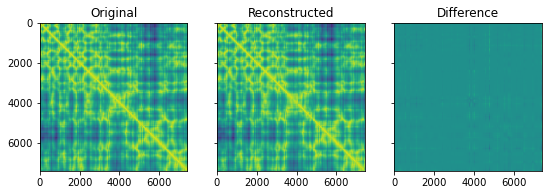

In [26]:
fig, ax = plt.subplots(1,3,figsize=(9, 3), sharey=True)
cmap = plt.get_cmap("viridis_r")

ax[0].set_title("Original")
ax[0].imshow(dist_mat, cmap="viridis_r")
ax[1].set_title("Reconstructed")
ax[1].imshow(new_dist_mat, cmap="viridis_r")
ax[2].set_title("Difference")
ax[2].imshow(delta_dist, cmap="viridis_r")


print("Diffs: max = {0} and min {1}".format(np.amax(delta_dist.numpy()),
                                            np.amin(delta_dist.numpy()) ))

In [27]:
# save pdb file and check manually here: 
# https://molstar.org/viewer/
buffer_save = mdtraj.load("data/1h22_protein_chain_1.pdb")
buffer_save.xyz = pred_mod.T[None, :, :]
buffer_save.save("data/save_to_check.pdb")

In [28]:
# save pdb file and check manually here: 
# https://molstar.org/viewer/
buffer_save = mdtraj.load("data/1h22_protein_chain_1.pdb")
buffer_save.xyz = prot_mod.T[None, :, :]
buffer_save.save("data/save_to_check_base.pdb")

Legend:
* blue/purple: reference
* green/orange: our reconstruction

Comments: only small blue detail on the left. increase match by decreasing tolerance

<img src="data/comparison.png">